# Read Turbulent Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lacbox.io import load_stats, load_oper
from pathlib import Path


BB_PATH = Path.cwd().parent / 'our_design/BB_turb_stats.csv'  # path to mean steady stats
DTU_PATH = Path.cwd().parent / 'dtu_10MW/turb/dtu_10mw_turb_stats.hdf5'  # path to mean steady stats
SUBFOLDER = 'tca'
SEEDS = 6

# Dict to identify which HAWC2 descriptions correspond to which channels
CHAN_DESCS = {'BldPit': 'pitch1 angle',
              'RotSpd': 'rotor speed',
              'Thrust': 'aero rotor thrust',
              'GenTrq': 'generator torque',
              'ElPow': 'pelec',
              'TbFA': 'momentmx mbdy:tower nodenr:   1',
              'TbSS': 'momentmy mbdy:tower nodenr:   1',
              'YbTilt': 'momentmx mbdy:tower nodenr:  11',
              'YbRoll': 'momentmy mbdy:tower nodenr:  11',
              'ShftTrs': 'momentmz mbdy:shaft nodenr:   4',
              'OoPBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: hub1',
              'IPBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: hub1',
              'FlpBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: blade1',
              'EdgBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: blade1',
              'OoPHub': 'momentmx mbdy:hub1 nodenr:   1 coo: hub1',
              'IPHub': 'momentmy mbdy:hub1 nodenr:   1 coo: hub1',
              }

# what channels we want to plot
chan_ids = ['BldPit', 'RotSpd', 'Thrust', 'GenTrq', 'ElPow', 'TbFA', 'TbSS',
            'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

chan_labels = [
    'Pitch angle',
    'Rotor speed',
    'Thrust',
    'Generator torque',
    'Electrical power',
    'Tower-base FA',
    'Tower-base SS',
    'Yaw-bearing tilt',
    'Yaw-bearing roll',
    'Shaft torsion',
    'OoP root moment',
    'IP root moment'    
]

In [ ]:
def extract_and_order_statistics(wsps, chan_df, seeds):
    """
    Extract and order:
     - wsp, max, mean, min for the points
     - wsp, mean_max, mean_mean, mean_min for the mean lines
    """

    # extract hawc2 wind and channel to plot from the HAWC2 stats
    val_wsp, val_max, val_mean, val_min = chan_df['wsp'], chan_df['max'], chan_df['mean'], chan_df['min']
    val_wsp, val_max, val_mean, val_min = np.array(val_wsp), np.array(val_max), np.array(val_mean), np.array(val_min)
    i_val = np.argsort(val_wsp)

    # Get mean of max/mean/min
    mean_max = np.average(val_max[i_val].reshape(-1, seeds), axis=1)
    mean_mean = np.average(val_mean[i_val].reshape(-1, seeds), axis=1)
    mean_min = np.average(val_min[i_val].reshape(-1, seeds), axis=1)

    points = {
        'wsp': val_wsp[i_val],
        'max': val_max[i_val],
        'mean': val_mean[i_val],
        'min': val_min[i_val]
    }

    lines = {
        'wsp': wsps,
        'max': mean_max,
        'mean': mean_mean,
        'min': mean_min
    }

    return points, lines

The max of the lines_DTU["max"] is  364297.4736328125


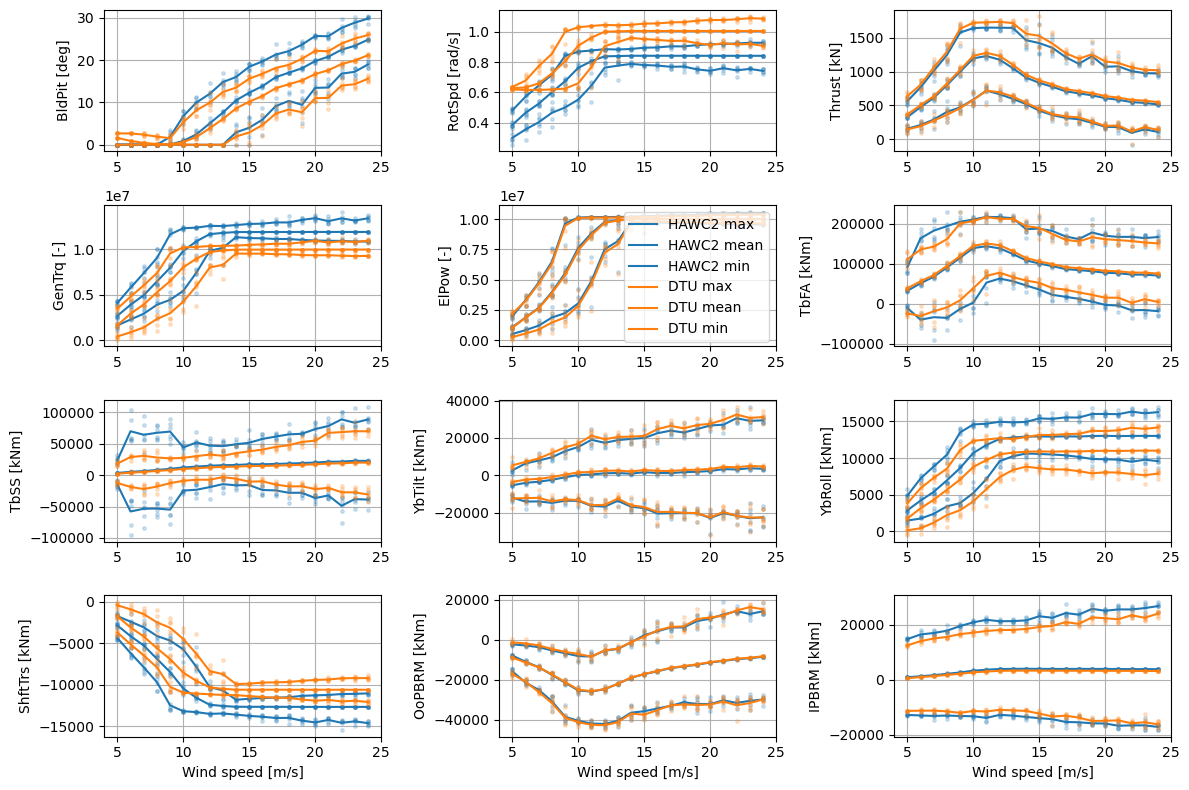

In [ ]:
# load the data from the stats file
df_BB, wsps_BB = load_stats(BB_PATH, subfolder=SUBFOLDER, statstype='turb')
df_DTU, wsps_DTU = load_stats(DTU_PATH, subfolder=SUBFOLDER, statstype='turb')


# initialize the figure and axes
fig, axs = plt.subplots(4, 3, figsize=(12, 8), clear=True)

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids):
    
    # isolate the channel data and get statistics
    chan_df_BB = df_BB.filter_channel(chan_id, CHAN_DESCS)
    chan_df_DTU = df_DTU.filter_channel(chan_id, CHAN_DESCS)

    # extract and order statistics
    points_BB, lines_BB = extract_and_order_statistics(wsps_BB, chan_df_BB, SEEDS)    
    points_DTU, lines_DTU = extract_and_order_statistics(wsps_DTU, chan_df_DTU, SEEDS)

    # For JIMALEXX
    if chan_id == 'TbFA':
        print('The max of the lines_DTU["max"] is ', np.max(lines_DTU['max']))

    # plot the results
    ax = axs.flatten()[iplot]
    ax.plot(points_BB['wsp'], points_BB['max'], '.', color='C0', alpha=0.2, markersize=5)
    ax.plot(points_BB['wsp'], points_BB['mean'], '.', color='C0', alpha=0.2, markersize=5)
    ax.plot(points_BB['wsp'], points_BB['min'], '.', color='C0', alpha=0.2, markersize=5)
    ax.plot(lines_BB['wsp'], lines_BB['max'], '-', color='C0', label='HAWC2 max')
    ax.plot(lines_BB['wsp'], lines_BB['mean'], '-', color='C0', label='HAWC2 mean')
    ax.plot(lines_BB['wsp'], lines_BB['min'], '-', color='C0', label='HAWC2 min')

    ax.plot(points_DTU['wsp'], points_DTU['max'], '.', color='C1', alpha=0.2, markersize=5)
    ax.plot(points_DTU['wsp'], points_DTU['mean'], '.', color='C1', alpha=0.2, markersize=5)
    ax.plot(points_DTU['wsp'], points_DTU['min'], '.', color='C1', alpha=0.2, markersize=5)
    ax.plot(lines_DTU['wsp'], lines_DTU['max'], '-', color='C1', label='DTU max')
    ax.plot(lines_DTU['wsp'], lines_DTU['mean'], '-', color='C1', label='DTU mean')
    ax.plot(lines_DTU['wsp'], lines_DTU['min'], '-', color='C1', label='DTU min')

    ax.grid('on')
    ax.set(xlabel='Wind speed [m/s]' if iplot > 8 else None,
           ylabel=f'{chan_id} [{chan_df_BB.units.iloc[0]}]', xlim=[4, 25])

axs[1, 1].legend()
fig.tight_layout()

plt.show()

# Seperate

In [ ]:
# load the data from the stats file
df_BB, wsps_BB = load_stats(BB_PATH, subfolder=SUBFOLDER, statstype='turb')
df_DTU, wsps_DTU = load_stats(DTU_PATH, subfolder=SUBFOLDER, statstype='turb')


# initialize the figure and axes
fig, axs = plt.subplots(4, 3, figsize=(12, 8), clear=True)

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids):
    
    # isolate the channel data and get statistics
    chan_df_BB = df_BB.filter_channel(chan_id, CHAN_DESCS)
    chan_df_DTU = df_DTU.filter_channel(chan_id, CHAN_DESCS)

    # extract and order statistics
    points_BB, lines_BB = extract_and_order_statistics(wsps_BB, chan_df_BB, SEEDS)    
    points_DTU, lines_DTU = extract_and_order_statistics(wsps_DTU, chan_df_DTU, SEEDS)

    # plot the results
    plt.figure(figsize=(5, 3))
    plt.plot(points_BB['wsp'], points_BB['max'], '.', color='C0', alpha=0.2, markersize=5)
    plt.plot(points_BB['wsp'], points_BB['mean'], '.', color='C0', alpha=0.2, markersize=5)
    plt.plot(points_BB['wsp'], points_BB['min'], '.', color='C0', alpha=0.2, markersize=5)
    plt.plot(lines_BB['wsp'], lines_BB['max'], '-', color='C0', label='HAWC2 max')
    plt.plot(lines_BB['wsp'], lines_BB['mean'], '-', color='C0', label='HAWC2 mean')
    plt.plot(lines_BB['wsp'], lines_BB['min'], '-', color='C0', label='HAWC2 min')

    plt.plot(points_DTU['wsp'], points_DTU['max'], '.', color='C1', alpha=0.2, markersize=5)
    plt.plot(points_DTU['wsp'], points_DTU['mean'], '.', color='C1', alpha=0.2, markersize=5)
    plt.plot(points_DTU['wsp'], points_DTU['min'], '.', color='C1', alpha=0.2, markersize=5)
    plt.plot(lines_DTU['wsp'], lines_DTU['max'], '-', color='C1', label='DTU max')
    plt.plot(lines_DTU['wsp'], lines_DTU['mean'], '-', color='C1', label='DTU mean')
    plt.plot(lines_DTU['wsp'], lines_DTU['min'], '-', color='C1', label='DTU min')

    ax.grid('on')
    ax.set(xlabel='Wind speed [m/s]' if iplot > 8 else None,
           ylabel=f'{chan_id} [{chan_df_BB.units.iloc[0]}]', xlim=[4, 25])

axs[1, 1].legend()
fig.tight_layout()

plt.show()